In [1]:
import matplotlib.pyplot as plt
import time
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### Define a simple time-dependent MLP

In [2]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.0):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]

class sMLP(nn.Module):
    def __init__(
        self, input_channel=1, output_channel=1, channels=[8, 32, 32, 32], embed_dim=32, embed_scale=30.0, act=nn.SiLU()
    ):
        super().__init__()
        self.denses = nn.ModuleList(
            [nn.Linear(embed_dim, channels[i]) for i in range(len(channels))]
        )
        self.layers = nn.ModuleList(
            [nn.Linear(input_channel, channels[0])]
            + [
                nn.Linear(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)
            ]
        )
        self.final = nn.Linear(channels[-1], output_channel)

        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim, scale=embed_scale),
            nn.Linear(embed_dim, embed_dim),
        )
        self.act = act

    def forward(self, h, t):
        embed = self.act(self.embed(t))
        for l, d in zip(self.layers, self.denses):
            cur_h = l(h)
            cur_h += d(embed)
            h = self.act(cur_h)

        h = self.final(h)

        return h

### Generate noisy data

In [10]:
sigma_noise = 0.2
batch_size = 1000
ori_points = torch.tensor(
    [
        [0, 1],
        [2**0.5 / 2, 2**0.5 / 2],
        [1, 0],
        [-(2**0.5) / 2, 2**0.5 / 2],
        [-1, 0],
        [-(2**0.5) / 2, -(2**0.5) / 2],
        [0, -1],
        [2**0.5 / 2, -(2**0.5) / 2],
    ]
)
points = ori_points.repeat(1000, 1)
val_points = ori_points.repeat(200, 1)
noisy_points = points + torch.randn_like(points) * sigma_noise
val_noisy_points = val_points + torch.randn_like(val_points) * sigma_noise

dataset = TensorDataset(noisy_points, points)
val_dataset = TensorDataset(val_points, val_noisy_points)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False, num_workers=1)


(-1.6544726312160491,
 1.6934427440166473,
 -1.5930215954780578,
 1.7313227295875548)

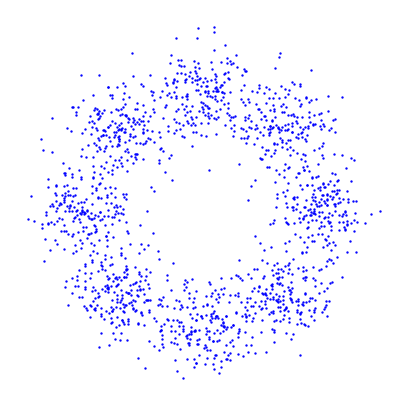

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.scatter(val_noisy_points[:, 0], val_noisy_points[:, 1], s=0.5, c='blue', zorder=10)

plt.axis('off')

## Inverse Flow

In [59]:
from importlib import reload
import train_utils
reload(train_utils)
from train_utils import createFlow, TrainLoop

config = {
    "checkpoint_path": "./checkpoints",
    "log_path": "./logs",
    "device": "cuda",
    "train": {
        "num_timesteps": 11,
        "batch_size": 1000,
        "lr": 1e-3,
        "n_epochs": 400,
        "schedule": {
            "t_min": 0.002,
            "t_max": 0.2,
            "t_data": 0.7,
            "rho": 7.0,
        },
        "save_interval": 100,
    },
}

## Inverse Consistency Model

In [60]:
config.update({
    "modelstr": "toyICM",
    "flow": {
            "type": "Gaussian",
            "sigma": 0.2,
            "algorithm": "icm",
        },
})

In [61]:
from model import ConsistencyModel
flow = createFlow(config)
model = sMLP(
        input_channel=2,
        output_channel=2,
        channels=[256, 256, 256, 256],
        embed_dim=256,
        embed_scale=1,
    )
model = ConsistencyModel(
                model,
                sigma_data=config["train"]["schedule"]["t_data"],
                sigma_min=config["train"]["schedule"]["t_min"],
            )
model.cuda()
trainloop = TrainLoop(model, flow, dataloader, config)

In [62]:
trainloop.train()

2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0: Avg Loss: 0.6936131194233894; Validation PSNR: 16.792731761932373
2025-02-13 11:54:26 - Epoch 0:

In [63]:
denoised_points = trainloop.predict(val_noisy_points)
# denoised_points = dfm.predict(model, val_noisy_points.float().cuda())

(-1.6544726312160491,
 1.6934427440166473,
 -1.5930215954780578,
 1.7313227295875548)

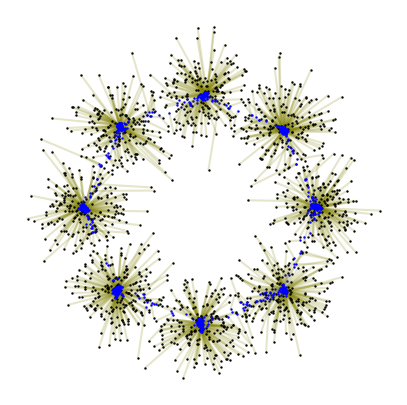

In [64]:
denoised_np = denoised_points.detach().cpu().reshape(-1, 2)
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
for idx in range(val_noisy_points.shape[0]):
    ax.plot([val_noisy_points[idx, 0], denoised_np[idx, 0]], [val_noisy_points[idx, 1], denoised_np[idx, 1]], c='olive', alpha=0.2, zorder=0)
ax.scatter(val_noisy_points[:, 0], val_noisy_points[:, 1], s=0.5, c='black', zorder=5)
ax.scatter(denoised_np[:, 0], denoised_np[:, 1], s=0.5, c='blue', zorder=10)

plt.axis('off')